In [1]:
import os, math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data loader class
class DataLoader():
    def __init__(self, image_size, batch_size):
        self.image_size = image_size
        self.batch_size = batch_size
        self.norm_factor = 255. / 2
    
    def preprocess(self, data):
        # Resize image to image_size
        data = tf.image.resize(data, self.image_size)
        # Normalize images to [-1, 1]
        ## As tanh activation is used
        return (data - self.norm_factor) / self.norm_factor
    
    def deprocess(self, data):
        return data * self.norm_factor + self.norm_factor
    
    def load(self, path):
        return keras.utils.image_dataset_from_directory(
            directory=path,
            image_size=self.image_size,
            batch_size=self.batch_size,
            shuffle=True,
            label_mode=None
        )\
        .map(self.preprocess)\
        .prefetch(1)\
        .cache()

In [3]:
# Method to build generator model
## Uses Keras Functional API
def build_G(
    image_size,
    w_init,
    filter_multiplier=32,
    out_strides = 16
):
    def builder(latent_dims):
        # [16, 8, 4, 2, 1]
        i = [2**n for n in range(0, 5)][::-1]
        filters = filter_multiplier
        final_strides = out_strides
        img_width = image_size[0] // final_strides
        img_height = image_size[1] // final_strides

        model_in = keras.layers.Input(shape=(latent_dims, ), name="gen-in")

        # Extract feature tensors using Dense layer
        x = keras.layers.Dense(i[0] * img_width * img_height * filters, use_bias=False)(model_in)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU(alpha=0.25)(x)

        # Reshape tensors to (w, h, c)
        x = keras.layers.Reshape((img_width, img_height, final_strides * filters))(x)

        # Upscale tensors using Conv2DTranspose layers
        for f in i[1:]:
            x = keras.layers.Conv2DTranspose(
                filters=f * filters,
                kernel_size=(5, 5),
                strides=2,
                padding='same',
                kernel_initializer=w_init,
                use_bias=False
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.LeakyReLU(alpha=0.25)(x)

        # Final deconv to convert tensors to (w, h, 3)
        x = keras.layers.Conv2D(
            filters=3,
            kernel_size=(5, 5),
            strides=1,
            kernel_initializer=w_init,
            padding='same',
            use_bias=False
        )(x)

        # Use tanh as final activation
        model_out = keras.layers.Activation('tanh')(x)

        return keras.models.Model(model_in, model_out, name='generator')
    return builder

In [4]:
# Method to build discriminator model
## Uses Keras Functional API
def build_D(
    image_size, 
    w_init,
    filter_multiplier=64,
    out_strides = 16
):
    def builder():
        # [1, 2, 4, 8]
        i = [2**n for n in range(0, 4)]
        filters = filter_multiplier
        final_strides = out_strides
        img_width = image_size[0] // final_strides
        img_height = image_size[1] // final_strides

        # Takes shape (w, h, c)
        model_in = keras.layers.Input(shape=(image_size[0], image_size[1], 3), name="dis-in")

        x = model_in
        # Downscale tensors using Conv2D layers
        for f in i:
            x = keras.layers.Conv2D(
                filters=f * filters,
                kernel_size=(5, 5),
                strides=2,
                padding='same',
                kernel_initializer=w_init,
                use_bias=False
            )(x)
            x = keras.layers.LeakyReLU(alpha=0.25)(x)
            x = keras.layers.Dropout(0.3)(x)

        # Flatten the output tensor
        x = keras.layers.Flatten()(x)
        # Feed the flattened tensor to a Dense layer for final output
        model_out = keras.layers.Dense(1)(x)

        return keras.models.Model(model_in, model_out, name='discriminator')
    return builder

In [5]:
# GAN model using Keras subclassing
class GAN(keras.models.Model):
    def __init__(self, build_generator, build_discriminator, latent_dims):
        super(GAN, self).__init__()
        self.latent_dims = latent_dims
        self.G = build_generator(self.latent_dims)
        self.D = build_discriminator()
        
    def compile(self, generator_optimizer, discriminator_optimizer, loss):
        super(GAN, self).compile()
        self.G_optimizer = generator_optimizer
        self.D_optimizer = discriminator_optimizer
        self.loss = loss
    
    def train_step(self, images):
        # Generate random latent vectors for discriminator training
        batch_size = tf.shape(images)[0]
        random_examples = tf.random.normal(shape=(batch_size, self.latent_dims))
        
        # Generate fake images using generator and random latent vectors
        fake_images = self.G(random_examples)
        
        # Combine generated and real images
        combined_images = tf.concat([
            fake_images,
            images
        ], axis=0)
        
        # Generate combined labels for combined images
        ## fake images = 0 and real images = 1
        combined_labels = tf.concat([
            tf.zeros(shape=(batch_size, 1)),
            tf.ones(shape=(batch_size, 1))
        ], axis=0)
        
        # Add random uniform noise to labels
        combined_labels += tf.random.uniform(tf.shape(combined_labels)) * 0.05
        
        # Train discriminator model
        with tf.GradientTape() as tape:
            predicted_labels = self.D(combined_images)
            D_loss = self.loss(combined_labels, predicted_labels)
        gradients = tape.gradient(D_loss, self.D.trainable_weights)
        self.D_optimizer.apply_gradients(zip(gradients, self.D.trainable_weights))
        
        # Sample random latent vectors for generator training
        random_examples = tf.random.normal(shape=(batch_size, self.latent_dims))
        
        # Create misleading labels to fool the discriminator during generator training
        misleading_labels = tf.ones(shape=(batch_size, 1))
        
        # Traing generator model
        ## Avoid updating weights of discriminator model
        with tf.GradientTape() as tape:
            predicted_labels = self.D(self.G(random_examples))
            G_loss = self.loss(misleading_labels, predicted_labels)
        gradients = tape.gradient(G_loss, self.G.trainable_weights)
        self.G_optimizer.apply_gradients(zip(gradients, self.G.trainable_weights))
        
        return {"g_loss": G_loss, "d_loss": D_loss}

In [6]:
# Constants
constants = {
    "dataset_path": "dataset/art-paintings",
    "image_size": (64, 64),
    "n_channels": 3,
    "batch_size": 64,
    "num_examples": 16,
    "latent_dims": 150,
    "epochs": 10,
}

In [7]:
# Load dataset
dataloader = DataLoader(image_size=constants["image_size"], batch_size=constants["batch_size"])

images = dataloader.load(path=constants["dataset_path"])

images

Found 8231 files belonging to 1 classes.


<CacheDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

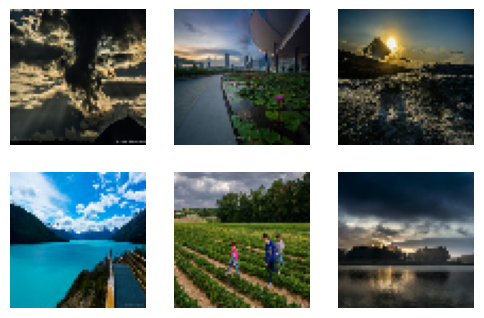

In [8]:
# Visualize images
plt.figure(figsize=(6, 6))
for batch in images.take(1):
    for i in range(6):
        plt.subplot(3, 3, i + 1)
        plt.imshow(dataloader.deprocess(batch[i].numpy()).astype(np.uint8))
        plt.axis('off')

In [9]:
# Setup GAN

# Weight initializer for conv and convT
w_init = keras.initializers.RandomNormal(mean=0., stddev=0.02)

# Optimizers
G_optimizer = keras.optimizers.Adam()
D_optimizer = keras.optimizers.Adam()

# Loss fn
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

gan = GAN(
    build_generator=build_G(image_size=constants["image_size"], w_init=w_init),
    build_discriminator=build_D(image_size=constants["image_size"], w_init=w_init),
    latent_dims=constants["latent_dims"]
)

In [10]:
gan.G.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gen-in (InputLayer)         [(None, 150)]             0         
                                                                 
 dense (Dense)               (None, 8192)              1228800   
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        3276800   
 nspose)                                                 

In [11]:
gan.D.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dis-in (InputLayer)         [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        4800      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       204800    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)     

In [12]:
# Compile gan
gan.compile(
    generator_optimizer=G_optimizer,
    discriminator_optimizer=D_optimizer,
    loss=loss_fn
)

# Fit gan
gan.fit(
    images,
    epochs=constants["epochs"]
)

Epoch 1/10
129/129 [==============================] - 40s 201ms/step - g_loss: 206.3544 - d_loss: 49.7557
Epoch 2/10
129/129 [==============================] - 23s 177ms/step - g_loss: 3050.8525 - d_loss: 50163.1665
Epoch 3/10
129/129 [==============================] - 22s 173ms/step - g_loss: 68722.8005 - d_loss: 15222.5396
Epoch 4/10
129/129 [==============================] - 23s 175ms/step - g_loss: 19337.5153 - d_loss: 37.0971
Epoch 5/10
129/129 [==============================] - 23s 177ms/step - g_loss: 26038.9904 - d_loss: -1943.7403
Epoch 6/10
129/129 [==============================] - 23s 178ms/step - g_loss: 23196.5415 - d_loss: 2218.7069
Epoch 7/10
129/129 [==============================] - 23s 179ms/step - g_loss: 6781.9959 - d_loss: -1841.7300
Epoch 8/10
129/129 [==============================] - 23s 180ms/step - g_loss: 57459.0548 - d_loss: 1082.4143
Epoch 9/10
129/129 [==============================] - 23s 179ms/step - g_loss: 4066805.1819 - d_loss: 1336710.7158
Epoch 10/

1/1 [==============================] - 0s 480ms/step


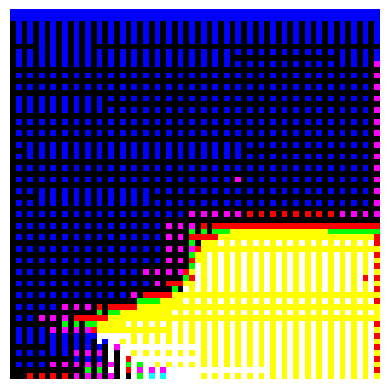

In [13]:
# Plot some images
n = 1
noise = np.random.normal(size=(n, constants["latent_dims"]))
examples = gan.G.predict(noise)

for i in range(n):
    plt.subplot(int(math.sqrt(n)), int(math.sqrt(n)), i+1)
    plt.axis("off")
    plt.imshow(dataloader.deprocess(examples[i]).astype(np.uint8))
plt.show()